In [1]:
import pandas as pd
import numpy as np
import h5py
from datetime import datetime, timedelta
import sys

from matplotlib.colors import TwoSlopeNorm, LogNorm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

import geopandas as gpd

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import textwrap

In [2]:
folder_path = "../"
sys.path.append(folder_path)
sys.path.append("../mobility_function/")
from mobility_function import analysis as ma
from importlib import reload
import mobility_function.analysis as ma
import mobility_function.hurricane_plotting as mhp
ma = reload(ma)
mhp = reload(mhp)
print(dir(ma))

['MO', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'array_summary', 'cos_sim', 'datetime', 'get_diagonal', 'get_diagonal_prob', 'get_mondays', 'get_travelling_out', 'h5py', 'h5py_to_4d_array', 'np', 'pd', 'region_mobility', 'region_out_desitination', 'relativedelta', 'relave_diff_D', 'test', 'timedelta']


In [3]:
cutoff_mile = 50

In [4]:
with h5py.File('flow_data_helene_{}miles_exclude.h5'.format(cutoff_mile), 'r') as h5file:
    change_helene = h5file['change_in_flow'][:]  
    base_helene = h5file['base_in_flow'][:]      

with h5py.File('flow_data_milton_{}miles_exclude.h5'.format(cutoff_mile), 'r') as h5file:
    change_milton = h5file['change_in_flow'][:]  
    base_milton = h5file['base_in_flow'][:]   

In [5]:
print (base_helene.shape)
base_helene_all_cate = np.sum(base_helene,axis=0)
base_helene_all_rg = np.sum(base_helene_all_cate,axis=1)
print ('shape for base helene',base_helene_all_rg.shape)
print (base_milton.shape)
base_milton_all_cate = np.sum(base_milton,axis=0)
base_milton_all_rg = np.sum(base_milton_all_cate,axis=1)
print ('shape for base milton',base_milton_all_rg.shape)

(17, 231, 270)
shape for base helene (231,)
(17, 310, 21)
shape for base milton (310,)


In [6]:
def get_pop_selected_rg(cutoff_mile,hurricane):
    with open("../results/{}/counties_geoid_cut_{}.txt".format(hurricane, cutoff_mile), "r") as f:
        county_list = [line.strip() for line in f]
    county_list = [int(x) for x in county_list]
    geo_idx = pd.read_csv('geoid_idx_names.csv')
    selected_idx = geo_idx[geo_idx['GEOID'].isin(county_list)].county_idx.values
    print('no of selected counties',len(selected_idx))

    selected_geoid = geo_idx[geo_idx['GEOID'].isin(county_list)].GEOID.values
    df_eco = pd.read_csv('demographic_socialeco_2021.csv')[['GEOID','Population']]
    # df_destination = df_destination.merge(df_eco, on='GEOID', how='left')
    # pop = df_destination.Population.values
    tot_pop = df_eco[df_eco['GEOID'].isin(selected_geoid)].Population.sum()
    print ('total population of selected counties',tot_pop)
    
    return tot_pop

In [7]:
pop_milton = get_pop_selected_rg(cutoff_mile,"milton")
pop_helene = get_pop_selected_rg(cutoff_mile,"helene")

no of selected counties 21
total population of selected counties 9889433
no of selected counties 270
total population of selected counties 14490828


In [8]:
change_helene.shape, change_milton.shape

((3, 17, 231, 270), (3, 17, 310, 21))

helene max: 2.8654975860235825
milton max: 29.600407319756957
KS Statistic: 0.27973746683424106
P-value: 1.2434379018939561e-09
Reject the null hypothesis: the datasets likely come from different distributions.
helene max: 23.562069097807747
milton max: 10.313293282752749
KS Statistic: 0.18592375366568914
P-value: 0.0001743007558540737
Reject the null hypothesis: the datasets likely come from different distributions.
helene max: 1.6191833829481808
milton max: 4.497785592501897
KS Statistic: 0.23364055299539171
P-value: 7.780127170920589e-07
Reject the null hypothesis: the datasets likely come from different distributions.


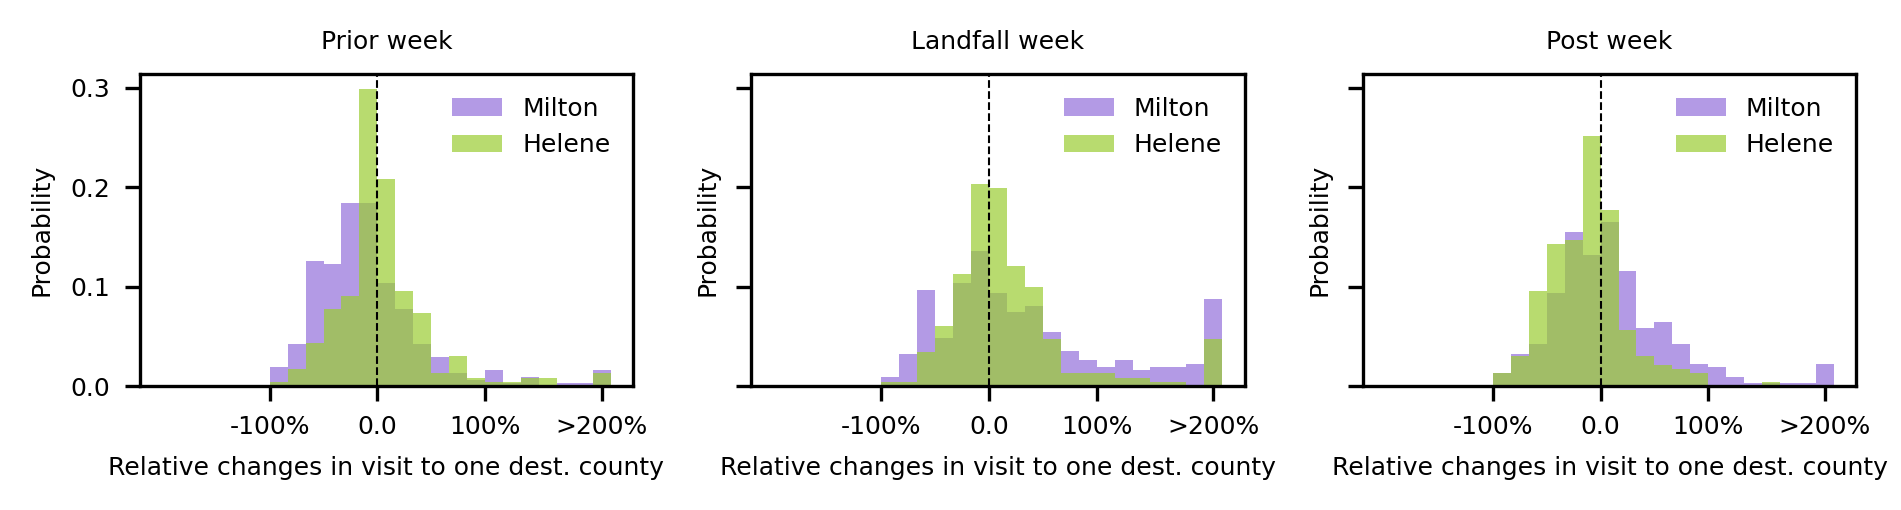

In [ ]:
m_relative_change_helene = np.zeros((3,change_helene.shape[2]))
m_relative_change_milton = np.zeros((3,change_milton.shape[2]))

from scipy.stats import gaussian_kde
from scipy.stats import ks_2samp
fig, axs = plt.subplots(1, 3, figsize=(6.5, 1.8), sharey=True, dpi=300)
for i in range(3):
    ax = axs[i]
    p_name = ['Prior week', 'Landfall week', 'Post week'][i]
    
    # Summing data
    change_helene_all_cate = np.sum(change_helene[i], axis=0)
    change_helene_all_rg = np.sum(change_helene_all_cate, axis=1)

    change_milton_all_cate = np.sum(change_milton[i], axis=0)
    change_milton_all_rg = np.sum(change_milton_all_cate, axis=1)
    
    # Relative changes
    helene_data = (change_helene_all_rg / base_helene_all_rg)
    m_relative_change_helene[i] = helene_data
    print('helene max:', np.max(helene_data))
    milton_data = (change_milton_all_rg / base_milton_all_rg)
    m_relative_change_milton[i] = milton_data
    print('milton max:', np.max(milton_data))

    statistic, p_value = ks_2samp(helene_data, milton_data)
    print(f"KS Statistic: {statistic}")
    print(f"P-value: {p_value}")
    # Interpret results
    alpha = 0.05
    if p_value > alpha:
        print("Fail to reject the null hypothesis: the datasets likely come from the same distribution.")
    else:
        print("Reject the null hypothesis: the datasets likely come from different distributions.")
    
    # Define custom bins: -0.1 to 0.1 in steps and one for >0.1
    # my_bins = np.concatenate([np.linspace(-0.1*100_000, 0.1*100_000, 31), [0.67*100_000]])
    my_bins = np.concatenate([np.linspace(-2, 2, 25), [30]])

    # Compute histograms with custom bins
    milton_hist, milton_edges = np.histogram(milton_data, bins=my_bins, density=False)
    helene_hist, helene_edges = np.histogram(helene_data, bins=my_bins, density=False)
    # print('hist',milton_hist)
    
    wd_m = np.diff(milton_edges)
    wd_m[-1] = wd_m[0]
    wd_h = np.diff(helene_edges)
    wd_h[-1] = wd_h[0]

    # Calculate bin centers
    milton_bin_centers = (milton_edges[:-1] + milton_edges[1:]) / 2
    milton_bin_centers[-1] = milton_bin_centers[-2] + wd_m[0]
    # print('center',milton_bin_centers)
    helene_bin_centers = (helene_edges[:-1] + helene_edges[1:]) / 2
    helene_bin_centers[-1] = helene_bin_centers[-2] + wd_h[0]

    # Normalize histogram
    # milton_hist_density = milton_hist / (sum(milton_hist) * wd_m[0])
    # helene_hist_density = helene_hist / (sum(helene_hist) * wd_h[0])
    milton_hist_density = milton_hist / (sum(milton_hist))
    helene_hist_density = helene_hist / (sum(helene_hist))

    # Plot histograms
    ax.bar(milton_bin_centers, milton_hist_density, width=wd_m, align='center', 
           label='Milton', alpha=0.7, color='mediumpurple')
    ax.bar(helene_bin_centers, helene_hist_density, width=wd_h, align='center', 
           label='Helene', alpha=0.7, color='yellowgreen')
    
    # kde_milton = gaussian_kde(milton_data,bw_method=0.2)
    # kde_helene = gaussian_kde(helene_data,bw_method=0.3)
    # x_vals = np.linspace(-0.06, 0.1, 500)
    # ax.plot(x_vals, kde_milton(x_vals), color='mediumpurple',lw=1.,ls='--')
    # ax.plot(x_vals, kde_helene(x_vals), color='yellowgreen',lw=1.,ls='--')

    # Set custom tick positions and labels
    xticks = [-1, 0.0, 1, 2.08333333]  # Custom tick positions
    xtick_labels = ['-100%', '0.0', '100%', '>200%']  # Corresponding labels
    # ax.set_xlim(-0.11*100_000,0.11*100_000)
    # # ax.set_ylim(0.7,210)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, fontsize=6)
    ax.tick_params(axis='y', labelsize=6)
    
    # Customizations
    ax.legend(frameon=False, fontsize=6)
    ax.axvline(0, color='black', linestyle='--', lw=0.5)
    # ax.set_xlabel('Change in number of visits per 100K population', size=6)
    ax.set_xlabel('Relative changes in visit to one dest. county',size=6)
    ax.set_ylabel('Probability', size=6)
    # ax.set_yscale('log')
    ax.set_title(f'{p_name}', size=6)
    
plt.tight_layout()
# plt.savefig('../results/relative_change_{}miles_exclude_pdf.png'.format(cutoff_mile),bbox_inches='tight',transparent=True)

* i choose 25 as number of bins to include 50% and 100% as the bin edges
* there are 12 bins < 0 and 12+1 bins > 0
* the 25th bin is the bin that larger than 2
* > 50% helene_edges[15:]
* > 100% helene_edges[18:]
* between -10% and 10% just calculate the number directly

In [166]:
np.sum(m_relative_change_milton[2]>=0.5)/310

np.float64(0.1935483870967742)

In [161]:
m_relative_change_milton[0].shape, m_relative_change_helene[0].shape

((310,), (230,))

In [168]:
np.sum(m_relative_change_helene[2]<0)/230

np.float64(0.6782608695652174)

In [117]:
def count_counties(data):
    count = np.zeros(3)
    count[0] = np.sum((data >=-0.1)&(data <=0.1))
    count[1] = np.sum(data >= 0.5)
    count[2] = np.sum(data >= 1)
    return count

In [143]:
for i in range(3):
    print('week',i)
    print('helene',count_counties(m_relative_change_helene[i]))
    print('milton',count_counties(m_relative_change_milton[i]))

week 0
helene [127.  32.   9.]
milton [45. 25. 10.]
week 1
helene [108.  45.  23.]
milton [41. 81. 51.]
week 2
helene [97. 14.  5.]
milton [69. 46. 12.]


### The following contents are not present in the MS

In [ ]:
def get_selected_pop_df(cutoff_mile,hurricane,change_h_all_dst):
    with open("../results/{}/counties_geoid_cut_{}.txt".format(hurricane, cutoff_mile), "r") as f:
        county_list = [line.strip() for line in f]
    county_list = [int(x) for x in county_list]
    geo_idx = pd.read_csv('geoid_idx_names.csv')
    df_eco = pd.read_csv('demographic_socialeco_2021.csv')[['GEOID','Population']]
    geo_pop = geo_idx.merge(df_eco, on='GEOID', how='left')
    geo_pop_selected = geo_pop[geo_pop['GEOID'].isin(county_list)]
    geo_pop_selected.sort_values(by='county_idx', ascending=True,inplace = True)
    geo_pop_selected.loc[:,'change_out'] = change_h_all_dst
    geo_pop_selected.loc[:,'change_out_per_pop'] = (geo_pop_selected['change_out']/geo_pop_selected['Population'])*100
    return geo_pop_selected

(230, 271)
(271,)
(310, 21)
(21,)
(230, 271)
(271,)
(310, 21)
(21,)
(230, 271)
(271,)
(310, 21)
(21,)


/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_68926/2559035443.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_pop_selected.sort_values(by='county_idx', ascending=True,inplace = True)
/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_68926/2559035443.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_pop_selected.loc[:,'change_out'] = change_h_all_dst
/var/folders/_0/2l3z2qss74scb88wvbv1szxr0000gn/T/ipykernel_68926/2559035443.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Text(0.5, 0.98, 'Distribution of change per pop in flow out to top 95% destination counties (excluding the selected regions) for 50 mile cut-off')

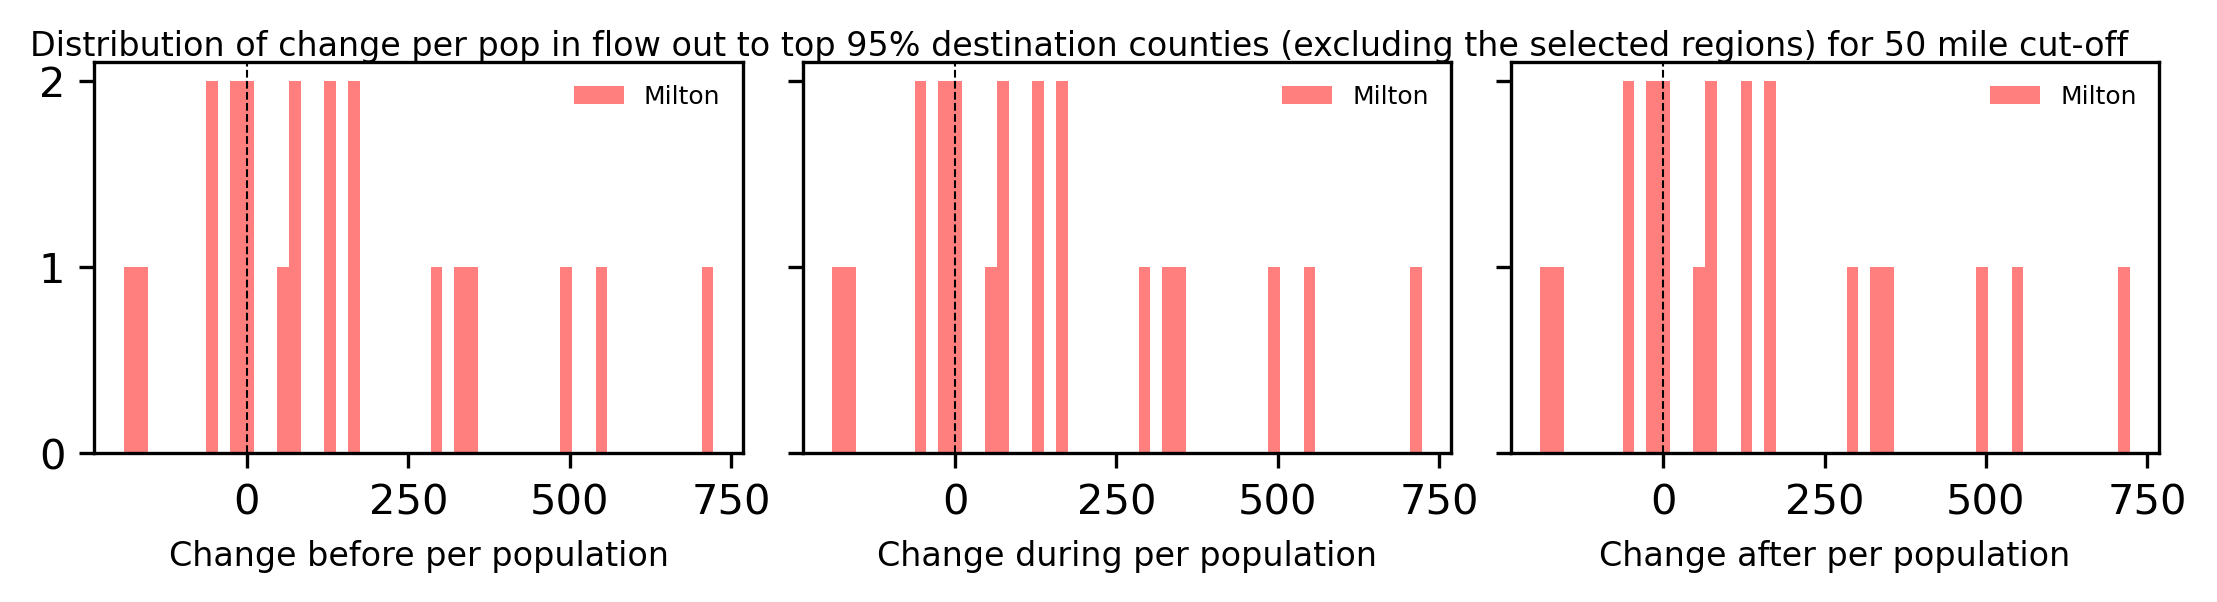

In [170]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2), sharey=True, dpi= 300)
for i in range(3):
    ax = axs[i]
    p_name = ['before','during','after'][i]
    change_helene_all_cate = np.sum(change_helene[1],axis=0)
    print(change_helene_all_cate.shape)
    change_helene_all_dst = np.sum(change_helene_all_cate,axis=0)
    print(change_helene_all_dst.shape)

    change_milton_all_cate = np.sum(change_milton[1],axis=0)
    print(change_milton_all_cate.shape)
    change_milton_all_dst = np.sum(change_milton_all_cate,axis=0)
    print(change_milton_all_dst.shape)
    cutoff_mile = 50
    geo_pop_selected_helene = get_selected_pop_df(cutoff_mile,"helene",change_helene_all_dst)
    geo_pop_selected_milton = get_selected_pop_df(cutoff_mile,"milton",change_milton_all_dst)
    change_rg_pop_helene = geo_pop_selected_helene.loc[:,'change_out_per_pop'].values
    change_rg_pop_milton = geo_pop_selected_milton.loc[:,'change_out_per_pop'].values
    
    # ax.hist(change_rg_pop_helene, bins=50,density=False,label='Helene',alpha=0.5,color='blue')
    ax.hist(change_rg_pop_milton, bins=50,density=False,label='Milton',alpha=0.5,color='red')
    ax.legend(frameon=False,fontsize=6)
    ax.axvline(0, color='black', linestyle='--',lw=0.5)
    ax.set_xlabel(f'Change {p_name} per population',size=8)
    # ax.set_ylabel('Dest County Counts',size=8)
    # ax.set_yscale('log')
    # ax.set_xscale('log')
plt.tight_layout()
plt.suptitle('Distribution of change per pop in flow out to top 95% destination counties (excluding the selected regions) for 50 mile cut-off',size=8)

In [ ]:
gdf = gpd.read_file('../data/county_geo/tl_2023_us_county/tl_2023_us_county.shp')
gdf['GEOID'] = gdf['GEOID'].astype(int)
projected_crs = "EPSG:5070"  # USA Contiguous Albers Equal Area
# storm_track = gdf_helene.to_crs(projected_crs)
county_centers = gdf.to_crs(projected_crs)
state_fp = pd.read_csv('state_fp.csv')
state_codes = state_fp['State (FIPS)'].unique() ### in total 52 states
gdf_states = county_centers[county_centers['STATEFP'].astype(int).isin(state_codes)]
geo_idx = pd.read_csv('geoid_idx_names.csv')
gdf_states_idx = gdf_states.merge(geo_idx, on=['NAME','GEOID'],how='right')

### for plotting
mainland_state_codes = np.array(list(set(state_codes) - set([2, 15]))) ## drop Alaska and Hawaii in total 50 states
gdf_main = gdf_states[gdf_states['STATEFP'].astype(int).isin(mainland_state_codes)]

In [ ]:
# Path to your shapefile
hurricane = 'helene'
with open("../results/{}/counties_geoid_cut_{}.txt".format(hurricane, cutoff_mile), "r") as f:
    county_list = [line.strip() for line in f]
county_list = [int(x) for x in county_list]
gdf_helene = gdf_states_idx[gdf_states_idx['GEOID'].isin(county_list)].copy()
print(len(gdf_helene))

gdf_helene_out = gdf_helene.merge(geo_pop_selected_helene, on='GEOID', how='left')


271


In [165]:
hurricane = 'milton'
with open("../results/{}/counties_geoid_cut_{}.txt".format(hurricane, cutoff_mile), "r") as f:
    county_list = [line.strip() for line in f]
county_list = [int(x) for x in county_list]
gdf_milton = gdf_states_idx[gdf_states_idx['GEOID'].isin(county_list)].copy()
print(len(gdf_milton))

gdf_milton_out = gdf_milton.merge(geo_pop_selected_milton, on='GEOID', how='left')

21


In [130]:
import matplotlib.colors as mcolors
from matplotlib.colors import SymLogNorm
from matplotlib.colors import Normalize

In [171]:
def plot_rg_change_map(gdf_h_out):
    norm = Normalize(vmin=-500, vmax=500)
    cmap = plt.get_cmap("coolwarm")
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi= 300)
        # Apply normalization to data
    gdf_h_out['color'] = gdf_helene_out['change_out_per_pop'].apply(lambda x: cmap(norm(x)))
    gdf_h_out.plot(ax=ax, color=gdf_helene_out['color'], edgecolor='white', lw=0.1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('difference in move out per 100 pop', fontsize=6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
# ax.set_title(f'change {name_m_ls[i]} landing (Helene)', fontsize=6)

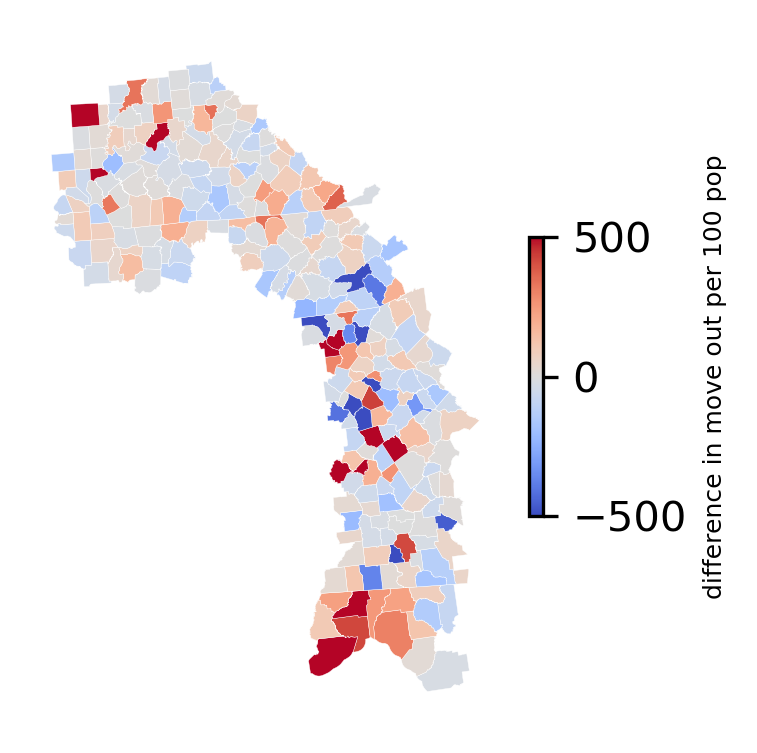

In [172]:
plot_rg_change_map(gdf_helene_out)

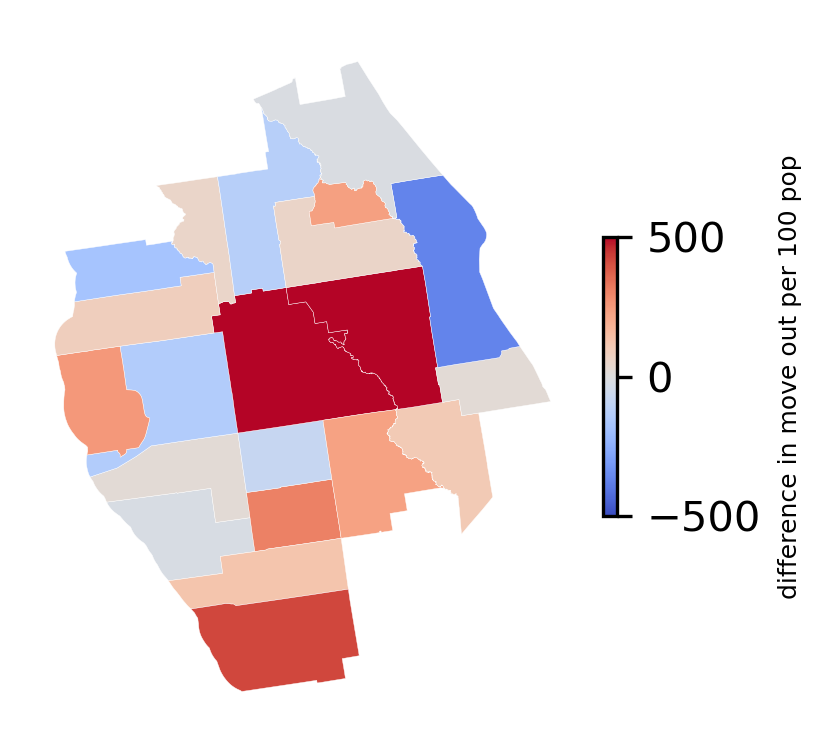

In [173]:
plot_rg_change_map(gdf_milton_out)